In [295]:
import numpy as np
import pandas as pd
import sys
from sklearn import preprocessing
from sklearn.pipeline import FeatureUnion, Pipeline, make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn import tree
import sklearn.model_selection as model_selection
import re

In [296]:
class SentenceEmbeddingTransform():
    def __init__(self, vocab, W_norm):
        self.W_norm = W_norm
        self.vocab = vocab
    
    def fit(self, X, y = None):
        return self
    
    def mean_of_word_embedding(self, input_term):
        words_inDict = np.empty([0])
        
        for idx, term in enumerate(re.split(' +', input_term)):
            if term in self.vocab:
                words_inDict = np.append(words_inDict, term)
                
        vec_sentence_embed = [self.W_norm[self.vocab[y], :] for y in words_inDict]
        vec_sentence_embed_stack = np.vstack(vec_sentence_embed)
        vec_sentence_embed_stack_mean = np.mean(vec_sentence_embed_stack, axis=0)
        
        return vec_sentence_embed_stack_mean
    
    def transform(self, X, y = None):
        ret_array = []
        
        for sentence in X:
            arr_result = self.mean_of_word_embedding(sentence.lower())
            ret_array.append(arr_result)

        return np.array(ret_array)
    
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

In [297]:
class LabelMappingTransform():
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        return np.array(X).reshape(-1, 1)
    
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X).reshape(-1, 1)


In [298]:
class MyLabelEncoder():

    def transform(self, X, y=None, **fit_params):
        enc = preprocessing.LabelEncoder()
        encc = enc.fit(X)
        enc_data = enc.transform(X).reshape(-1, 1)

        return enc_data

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X).reshape(-1, 1)

    def fit(self, X, y=None, **fit_params):
        return self

In [299]:
vector_file = "D:\\ARTIFICIAL INTELLIGENCE\\2020\\Word2Vec\\CBOW\\TXT\\corpus-plus-simral-40-1-vector.txt"
vocab_file = "D:\\ARTIFICIAL INTELLIGENCE\\2020\\Word2Vec\\CBOW\\TXT\\corpus-plus-simral-40-1-vocab.txt"

with open(vocab_file, 'r', encoding='utf-8') as f:
    words = [x.rstrip().split(' ')[0] for x in f.readlines()]
    
with open(vector_file, 'r', encoding='utf-8') as f:
    vectors = {}
    for line in f:
        vals = line.rstrip().split(' ')
        vectors[vals[0]] = [float(x) for x in vals[1:]]

vocab_size = len(words)
vocab = {w: idx for idx, w in enumerate(words)}
ivocab = {idx: w for idx, w in enumerate(words)}

vector_dim = len(vectors[ivocab[0]])
W = np.zeros((vocab_size, vector_dim))
for word, v in vectors.items():
    if word == '<unk>':
        continue
    W[vocab[word], :] = v
    
W_norm = np.zeros(W.shape)
d = (np.sum(W ** 2, 1) ** (0.5))

W_norm = (W.T / d).T


In [300]:
csvPath = "D:\\ARTIFICIAL INTELLIGENCE\\2020\\KLASIFIKASI\\labeled_2019_merged - Copy.csv"

data = pd.read_csv(csvPath)

data['label'] = data['label'].fillna(value=0.0)
data.shape

data = data.dropna(axis=0, subset=['namaprogram', 'namaoutput', 'namaoutcome', 'namakegiatan', 'satuanoutput', 'satuanoutcome'])

In [301]:
import re

# drop digit in sentences
data['clean_namaoutcome'] = data['namaoutcome'].str.lower().apply(lambda input_term : re.sub('[0-9,;\/]+', '', input_term))
data['clean_namaoutput'] = data['namaoutput'].str.lower().apply(lambda input_term : re.sub('[0-9,;\/]+', '', input_term))
data['clean_namaprogram'] = data['namaprogram'].str.lower().apply(lambda input_term : re.sub('[0-9,;\/]+', '', input_term))
data['clean_namakegiatan'] = data['namakegiatan'].str.lower().apply(lambda input_term : re.sub('[0-9,;\/]+', '', input_term))

In [302]:
sat_outcome_unique = data['satuanoutcome'].str.lower().unique()
sat_output_unique = data['satuanoutput'].str.lower().unique()

dict_sat_outcome = {}

for i in range(len(sat_outcome_unique)):
    dict_sat_outcome[sat_outcome_unique[i]] = i
    
dict_sat_output = {}

for j in range(len(sat_output_unique)):
    dict_sat_output[sat_output_unique[j]] = j 

In [303]:
data['label_satuanoutcome'] = data['satuanoutcome'].str.lower().apply(lambda x : dict_sat_outcome[x])
data['label_satuanoutput'] = data['satuanoutput'].str.lower().apply(lambda x : dict_sat_output[x])

In [304]:
np.save('dict_satuanoutcome.npy', dict_sat_outcome) 
np.save('dict_satuanoutput.npy', dict_sat_output) 

In [305]:
def get_label_satuan_outcome(df):
    return df['label_satuanoutcome']

def get_label_satuan_output(df):
    return df['label_satuanoutput']

def get_text_satuan_outcome(df):
    return df['satuanoutcome']

def get_text_satuan_output(df):
    return df['satuanoutput']

def get_text_nama_program(df):
    return df['clean_namaprogram']

def get_text_nama_kegiatan(df):
    return df['clean_namakegiatan']

def get_text_nama_output(df):
    return df['clean_namaoutput']

def get_text_nama_outcome(df):
    return df['clean_namaoutcome']

vec = make_union(*[
#     make_pipeline(FunctionTransformer(get_text_satuan_outcome, validate=False), MyLabelEncoder()),
#     make_pipeline(FunctionTransformer(get_text_satuan_output, validate=False), MyLabelEncoder()),
    make_pipeline(FunctionTransformer(get_label_satuan_outcome, validate=False), LabelMappingTransform()),
    make_pipeline(FunctionTransformer(get_label_satuan_output, validate=False), LabelMappingTransform()),
    make_pipeline(FunctionTransformer(get_text_nama_program, validate=False), SentenceEmbeddingTransform(vocab, W_norm)),
    make_pipeline(FunctionTransformer(get_text_nama_kegiatan, validate=False), SentenceEmbeddingTransform(vocab, W_norm)),
    make_pipeline(FunctionTransformer(get_text_nama_output, validate=False), SentenceEmbeddingTransform(vocab, W_norm)),
    make_pipeline(FunctionTransformer(get_text_nama_outcome, validate=False), SentenceEmbeddingTransform(vocab, W_norm))
])

In [306]:
neo_pipeline = Pipeline([
    ('thevec', vec),
    ('dectree', tree.DecisionTreeClassifier())  # classifier
])

data_column_used = data[['clean_namaprogram', 'label_satuanoutcome', 'label_satuanoutput', 'clean_namakegiatan', 'clean_namaoutput', 'clean_namaoutcome', 'satuanoutcome', 'satuanoutput']]
data_target = data['label'].astype(int)

In [323]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_column_used, data_target, test_size=0.1,random_state=42)


In [324]:
neo_pipeline.fit(X_train, y_train)

labels = neo_pipeline.predict(X_test)

X_train.shape

(1803, 8)

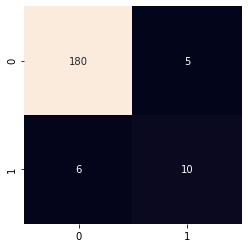

In [325]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib as plt
mat = confusion_matrix(labels, y_test)

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'], yticklabels=['0', '1'])

In [326]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, labels)

0.945273631840796

In [327]:
from sklearn.metrics import classification_report

print (classification_report(y_test, labels, target_names=['non-doc', 'doc']))

              precision    recall  f1-score   support

     non-doc       0.97      0.97      0.97       185
         doc       0.67      0.62      0.65        16

    accuracy                           0.95       201
   macro avg       0.82      0.80      0.81       201
weighted avg       0.94      0.95      0.94       201



In [330]:
import joblib
joblib.dump(neo_pipeline, 'mowe_pipeline_model_train.pkl') 

['mowe_pipeline_model_train.pkl']